## Making an Test UI using Gradio 🖥️

In [28]:
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import gradio as gr
import pickle

In [29]:
# function which is returning the number of object detected 
def number_object_detected(image):
    
    custom_model = YOLO('D:/COMSATS/FYP/Coding Part/ModelMaking/Computer_Vision_Part/4th Try/runs/detect/train4/weights/best.pt') # custome yolo model path
    results = custom_model(image,verbose= False)

    dic = results[0].names
    classes = results[0].boxes.cls.cpu().numpy()
    probability = results[0].boxes.conf

    class_count = {}
    unique_elements, counts = np.unique(classes, return_counts=True)
    for e , count in zip(unique_elements,counts):
        a = dic[e]
        class_count[a] = count
    #print(class_count)

    
    """for r in results:
        im_array = r.plot(pil = True)  # plot a BGR numpy array of predictions
        array = im_array[..., ::-1]  # Convert BGR to RGB PIL image
        plt.axis("off")
        plt.imshow(array)
        plt.show()"""
    
    return (class_count,results )


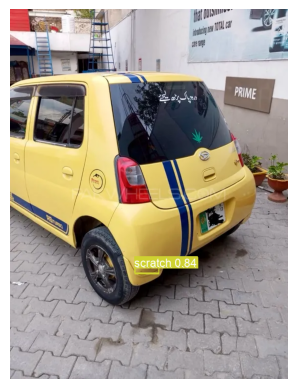

({'scratch': 2},
 [ultralytics.engine.results.Results object with attributes:
  
  boxes: ultralytics.engine.results.Boxes object
  keypoints: None
  masks: None
  names: {0: 'crack', 1: 'dent', 2: 'paint-damage', 3: 'rust', 4: 'scratch'}
  obb: None
  orig_img: array([[[ 61,  54, 210],
          [ 61,  54, 210],
          [ 63,  56, 212],
          ...,
          [119, 100,  62],
          [145, 126,  86],
          [171, 153, 113]],
  
         [[ 61,  54, 210],
          [ 61,  54, 210],
          [ 61,  54, 210],
          ...,
          [131, 111,  75],
          [160, 141, 103],
          [183, 164, 126]],
  
         [[ 77,  70, 226],
          [ 77,  70, 226],
          [ 77,  70, 226],
          ...,
          [146, 128,  94],
          [178, 159, 126],
          [197, 179, 146]],
  
         ...,
  
         [[152, 149, 152],
          [143, 140, 142],
          [150, 147, 149],
          ...,
          [155, 149, 155],
          [151, 144, 150],
          [148, 142, 148]],
 

In [30]:
number_object_detected("C:/Users/M_ros/Downloads/Testingimages/daihatsu-esse-vs-memorial-edition-2015-100286549.png")

In [31]:
def car_detection_and_Cropping(image_path):
    simple_yolo = YOLO('yolov8m.pt')
    r = simple_yolo(image_path,verbose = False)
    

    names = r[0].names
    boxes = r[0].boxes.xyxy.cpu().numpy().astype(int)
    classes = set(r[0].boxes.cls.cpu().numpy())
    classes2 =  [names[i] for i in classes]

    # checking if the detected object is the car or not 
    # if it is car then crop if not then pass the image as it is
    if boxes.size != 0 and 'car' in classes2:
      
      area = []
      for x1, y1, x2, y2 in boxes:
          area.append((x2 - x1) * (y2 - y1))
      max_index, max_a = max(enumerate(area), key=lambda x: x[1])
      

      # Load the image using OpenCV
      image = cv2.imread(image_path)
      
      # Crop the image
      crop_image = image[boxes[max_index][1]:boxes[max_index][3], boxes[max_index][0]:boxes[max_index][2]]

      # passing the crop image to the detection model

      class_c ,result = number_object_detected(crop_image)
    else:
      class_c ,result= number_object_detected(image_path)
    return class_c ,result

In [32]:
severity_points = {
    'scratch': 1,
    'dent': 2,
    'rust': 2,
    'paint-damage': 2,
    'crack':2
}

def calculate_condition_score(detections):
    total_score = 0
    for detection, count in detections.items():
        if detection in severity_points:
            total_score += severity_points[detection] * count
    return total_score

def normalize_score(score, max_score):
    return (score / max_score) * 10

def estimate_condition(detections):
    print("Detedtion list",detections)
    max_possible_score = sum(severity_points.values())  # Assuming all types of damage detected
    score = calculate_condition_score(detections)
    normalized_score = normalize_score(score, max_possible_score)
    print("normalized Score",normalized_score)
    # Assign condition rating
    if normalized_score <= 4:  # If score is low, condition is Excellent
        
        return "Excellent"
    elif (normalized_score >4 and normalized_score <=7):  # If score is moderately low, condition is Good
       
        return "Good"
    elif (normalized_score >7 and normalized_score <15):  # If score is moderate, condition is Fair
        
        return "Fair"
    elif (normalized_score >15 and normalized_score<=20):  # If score is moderately high, condition is Poor
      
        return "Poor"
    else:  # If score is high, condition is Very Poor
       
        return "Very Poor"


In [33]:
import pickle 
with open('D:\COMSATS\FYP\Coding Part\Whole Process with Minor Changes\Visulization&Prediction\Price_prediction_decision_tree.pkl', 'rb') as file:
    loaded_pipe_lr = pickle.load(file)

In [34]:
## loading the model
def process_data(files,car_brand, car_name, model_year, mileage, city_registered, color, engine_c, trans, fuel_type, Cate):
    
    file_names = [f[0] for f in files]
    image_r = []
    
    
    damage_dic = {}

    for f in file_names:

        damage, result = car_detection_and_Cropping(f)
        for r in result:
            im_array = r.plot(pil = True)  # plot a BGR numpy array of predictions
            array = im_array[..., ::-1]  # Convert BGR to RGB PIL image
            image_r.append(array)
        for key in damage.keys():
                      if key in damage_dic:
                        damage_dic[key] += damage[key]
                      else:
                          damage_dic[key] = damage[key]
    condition = estimate_condition(damage_dic)


    price = loaded_pipe_lr.predict([[model_year,mileage,city_registered,color,engine_c,car_brand,car_name,trans,fuel_type,condition,Cate]])
    print(price)
    if price[0] >= 100:
          price[0] = price[0]/100
    
    return (condition , str(price[0])+'lacs' , image_r)

    



In [35]:
years_list = list(range(2024, 1899, -1))
gr.Interface(fn = process_data,
             inputs=[gr.Gallery(label="Upload Files", type="filepath"),
                  gr.Dropdown(['suzuki','toyota','honda','kia','changan'], label='Brand'),
                      gr.Textbox(lines=1, label="Car Name"),
                      gr.Dropdown(choices=years_list, label='Model Year'),
                      gr.Number(label="Mileage Km"),
                      gr.Textbox(lines=1, label="City Register"),
                      gr.Textbox(lines=1, label="Color"),
                      gr.Number(label="Engine Capacity in CC"),
                      gr.Radio(["automatic", "manual"], label="Transmission Type"),
                     # gr.Radio(["imported", "local"], label="Assembly Type"),
                      gr.Radio(["hybrid", "petrol",'diesel'], label="Fuel Type"),
                      gr.Radio(["hatchback", "sedan",'suv','croosover','van'], label="Category")],
                    outputs=[gr.Textbox(label="Condition"),gr.Textbox(label="Predicted Price"),gr.Gallery(label='output',type='pil')]).launch()

Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


IMPORTANT: You are using gradio version 4.18.0, however version 4.29.0 is available, please upgrade.
--------


C:\Users\M_ros\AppData\Local\Temp\ipykernel_27128\789608918.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


Detedtion list {'scratch': 3}
normalized Score 3.333333333333333
[         73]


c:\Users\M_ros\anaconda3\envs\fyp2\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
